In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.signal as signal
import pandas as pd
from tensorflow.keras.utils import pad_sequences

In [6]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.18.0


In [13]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid consuming all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled!")
    except RuntimeError as e:
        print(e)


In [8]:
!pip install wfdb

In [7]:
import wfdb
from wfdb import io

# dataset_path = "/content/mit-bih-arrhythmia-database"


# wfdb.dl_database('mitdb', dataset_path)

# dataset_path = "drive/MyDrive/dataset/input"
dataset_path = "dataset/input"


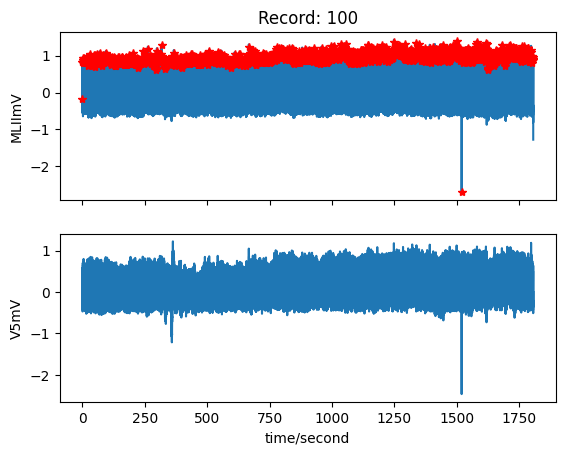

In [8]:
path = f'{dataset_path}/100'
record = wfdb.rdrecord(path)
ann = wfdb.rdann(path, 'atr')
ecg_signal = record.p_signal[:,0]
wfdb.plot_wfdb(record=record, annotation=ann)

In [9]:
class Preprocess:
    def __init__(self, path, std=True):
        self.path = path
        self.record = wfdb.rdrecord(path)
        self.fs = self.record.fs
        self.ecg_signal = self.record.p_signal[:,0]
        self.ann = wfdb.rdann(path, 'atr')
        self.cleaned_ecg = self.clean_signal(std)
        self.segments, self.target, self.target_encoded = self.create_features()


    def butter_bandpass(self, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs  # Nyquist frequency
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a

    def apply_bandpass_filter(self, data, lowcut, highcut, order=4):
        b, a = self.butter_bandpass(lowcut, highcut, self.fs, order)
        filtered_signal = signal.filtfilt(b, a, data)
        return filtered_signal

    def standardize_signal(self, filtered_signal):
        return (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)

    def clean_signal(self, std=True):
        filtered_signal = self.apply_bandpass_filter(self.ecg_signal, lowcut=0.5, highcut=40, order=4)
        if std == True:
          return self.standardize_signal(filtered_signal)
        return filtered_signal

    def create_features(self):
        segment = []
        for i in self.ann.sample:
            start = np.max([i-180, 0])
            end = np.min([i + 180, len(self.cleaned_ecg)])
            ecg_segment = self.cleaned_ecg[start:end]
            segment.append(ecg_segment)
        
        segment = pad_sequences(segment, maxlen=self.fs, padding='post', value=0)



        target = list(self.ann.symbol)

        aami_mapping = {
                            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',  # Normal Beats
                            'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',  # Supraventricular
                            'V': 'V', 'E': 'V',  # Ventricular
                            'F': 'F',  # Fusion
                            '/': 'Q', 'f': 'Q', 'Q': 'Q'  # Unknown/Paced
                        }

        aami_encoding = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        for i in range(0, len(target)):
             target[i] = aami_mapping.get(target[i], 'Q')

        target_encoded = []
        for i in range(0, len(target)):
            target_encoded.append(aami_encoding[target[i]])

        return np.array(segment), np.array(target), np.array(target_encoded)


    def plot_signal_annotations(self, range):
        if range > len(self.ecg_signal):
            range = 1000
        ann_range = [i for i in self.ann.sample if i <= range]
        ecg_segment = self.ecg_signal[:range]
        plt.plot(ecg_segment)
        plt.scatter(ann_range, ecg_segment[ann_range])

    def print_signal_features(self):
        print(f"Signal Data (first 5 samples):\n{self.record.p_signal[:5]}")
        print(f"Sampling Frequency (Hz): {self.record.fs}")
        print(f"Signal Names: {self.record.sig_name}")
        print(f"Signal Units: {self.record.units}")
        print(f"Number of Signals: {self.record.n_sig}")
        print(f"Record Comments: {self.record.comments}", end='\n\n')
        print("Annotations Sample Indices:", self.ann.sample[:10])
        print("Annotation Labels/Symbols:", self.ann.symbol[:10])
        print("Annotation Subtypes:", self.ann.subtype[:10])
        print("Auxiliary Notes:", self.ann.aux_note[:10])

        print(f"Total Annotations: {len(self.ann.sample)}")

In [10]:
dir_df = pd.read_csv('directory.csv')

In [11]:

final_segments = []
final_segments_wo_std = []
final_target = []
final_target_encoded = []
signal_name = []
for n in dir_df.name.values:
    file = n.split('.')[0]
    path = f'{dataset_path}/{file}'
    pp = Preprocess(path, std=True)
    pp_wo_std = Preprocess(path, std=False)
    final_segments.append(pp.segments)
    final_segments_wo_std.append(pp_wo_std.segments)
    final_target.append(pp.target)
    final_target_encoded.append(pp.target_encoded)
    signal_name.append([file]*len(pp.segments))

final_segments = np.concatenate(final_segments)
final_segments_wo_std = np.concatenate(final_segments_wo_std)
final_target = np.concatenate(final_target)
final_target_encoded = np.concatenate(final_target_encoded)
signal_name = np.concatenate(signal_name)




In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [13]:
X_train, X_test, y_train, y_test = train_test_split(final_segments, final_target_encoded, test_size=0.2, random_state=42, stratify=final_target_encoded)
X_train_wo_std, X_test_wo_std, _, _ = train_test_split(final_segments_wo_std, final_target_encoded, test_size=0.2, random_state=42, stratify=final_target_encoded)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_plot(y_true, y_pred):
    class_labels = ['N', 'S', 'V', 'F', 'Q']
    label_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

    # Ensure correct mapping from numbers to labels
    if isinstance(y_true[0], int) or isinstance(y_true[0], np.integer):
        y_true_labels = [label_mapping[label] for label in y_true]
        y_pred_labels = [label_mapping[label] for label in y_pred]
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred

    # Debugging: Print unique values
    print("Unique values in y_true_labels:", set(y_true_labels))
    print("Unique values in y_pred_labels:", set(y_pred_labels))

    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)

    # Compute classification report (handling missing classes)
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels, labels=class_labels, zero_division=0)
    print("\nClassification Report:\n", report)

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')



In [9]:

def stratified_kfold_cv(X, y, model, n_splits=10):

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store scores for each fold
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    scaler = StandardScaler()

    # Perform Stratified K-Fold Cross Validation
    for train_idx, val_idx in skf.split(X, y):
        # Get the training and validation sets for each fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred = model.predict(X_val_fold)

        # Calculate Precision, Recall, F1 Score, and Accuracy for the current fold
        precision = precision_score(y_val_fold, y_val_pred, average='weighted')
        recall = recall_score(y_val_fold, y_val_pred, average='weighted')
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')
        accuracy = accuracy_score(y_val_fold, y_val_pred)

        # Append the scores for the fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

        print(f"Fold Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Calculate and print the average scores across all folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("\nAverage Scores across all folds:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

In [69]:
model_nb = GaussianNB()
stratified_kfold_cv(X_train, y_train, model_nb, n_splits=10)
print('*' * 100)
print('without std')
stratified_kfold_cv(X_train_wo_std, y_train, model_nb, n_splits=10)

Fold Accuracy: 0.2085, Precision: 0.9183, Recall: 0.2085, F1 Score: 0.2821
Fold Accuracy: 0.2076, Precision: 0.9188, Recall: 0.2076, F1 Score: 0.2775
Fold Accuracy: 0.1840, Precision: 0.9201, Recall: 0.1840, F1 Score: 0.2446
Fold Accuracy: 0.2557, Precision: 0.9167, Recall: 0.2557, F1 Score: 0.3495
Fold Accuracy: 0.2110, Precision: 0.9211, Recall: 0.2110, F1 Score: 0.2850
Fold Accuracy: 0.2169, Precision: 0.9135, Recall: 0.2169, F1 Score: 0.2964
Fold Accuracy: 0.1908, Precision: 0.9145, Recall: 0.1908, F1 Score: 0.2543
Fold Accuracy: 0.1899, Precision: 0.9207, Recall: 0.1899, F1 Score: 0.2555
Fold Accuracy: 0.2184, Precision: 0.9195, Recall: 0.2184, F1 Score: 0.2970
Fold Accuracy: 0.2085, Precision: 0.9206, Recall: 0.2085, F1 Score: 0.2817

Average Scores across all folds:
Average Accuracy: 0.2091
Average Precision: 0.9184
Average Recall: 0.2091
Average F1 Score: 0.2824
****************************************************************************************************
without std


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.0566, Precision: 0.0767, Recall: 0.0566, F1 Score: 0.0396


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.0559, Precision: 0.0755, Recall: 0.0559, F1 Score: 0.0396


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.0572, Precision: 0.0776, Recall: 0.0572, F1 Score: 0.0418


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.0570, Precision: 0.0771, Recall: 0.0570, F1 Score: 0.0411


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.0569, Precision: 0.0727, Recall: 0.0569, F1 Score: 0.0399
Fold Accuracy: 0.0560, Precision: 0.0692, Recall: 0.0560, F1 Score: 0.0391
Fold Accuracy: 0.0566, Precision: 0.7679, Recall: 0.0566, F1 Score: 0.0417
Fold Accuracy: 0.0528, Precision: 0.0769, Recall: 0.0528, F1 Score: 0.0369
Fold Accuracy: 0.0558, Precision: 0.0736, Recall: 0.0558, F1 Score: 0.0398
Fold Accuracy: 0.0571, Precision: 0.0742, Recall: 0.0571, F1 Score: 0.0404

Average Scores across all folds:
Average Accuracy: 0.0562
Average Precision: 0.1441
Average Recall: 0.0562
Average F1 Score: 0.0400


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
model_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
stratified_kfold_cv(X_train, y_train, model_knn, n_splits=10)
print('*' * 100)
print('without std')
stratified_kfold_cv(X_train_wo_std, y_train, model_knn, n_splits=10)

Fold Accuracy: 0.9647, Precision: 0.9637, Recall: 0.9647, F1 Score: 0.9629
Fold Accuracy: 0.9675, Precision: 0.9661, Recall: 0.9675, F1 Score: 0.9658
Fold Accuracy: 0.9664, Precision: 0.9655, Recall: 0.9664, F1 Score: 0.9643
Fold Accuracy: 0.9687, Precision: 0.9674, Recall: 0.9687, F1 Score: 0.9668
Fold Accuracy: 0.9679, Precision: 0.9665, Recall: 0.9679, F1 Score: 0.9660
Fold Accuracy: 0.9660, Precision: 0.9642, Recall: 0.9660, F1 Score: 0.9640
Fold Accuracy: 0.9665, Precision: 0.9649, Recall: 0.9665, F1 Score: 0.9644
Fold Accuracy: 0.9684, Precision: 0.9672, Recall: 0.9684, F1 Score: 0.9660
Fold Accuracy: 0.9630, Precision: 0.9613, Recall: 0.9630, F1 Score: 0.9609
Fold Accuracy: 0.9683, Precision: 0.9670, Recall: 0.9683, F1 Score: 0.9664

Average Scores across all folds:
Average Accuracy: 0.9667
Average Precision: 0.9654
Average Recall: 0.9667
Average F1 Score: 0.9648
****************************************************************************************************
without std
Fold

In [71]:
model_rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, n_jobs=-1, random_state=42)
stratified_kfold_cv(X_train, y_train, model_rf, n_splits=10)
print('*' * 100)
print('without std')
stratified_kfold_cv(X_train_wo_std, y_train, model_rf, n_splits=10)

Fold Accuracy: 0.9685, Precision: 0.9681, Recall: 0.9685, F1 Score: 0.9650
Fold Accuracy: 0.9704, Precision: 0.9701, Recall: 0.9704, F1 Score: 0.9675
Fold Accuracy: 0.9682, Precision: 0.9677, Recall: 0.9682, F1 Score: 0.9639
Fold Accuracy: 0.9718, Precision: 0.9720, Recall: 0.9718, F1 Score: 0.9681
Fold Accuracy: 0.9711, Precision: 0.9710, Recall: 0.9711, F1 Score: 0.9680
Fold Accuracy: 0.9702, Precision: 0.9703, Recall: 0.9702, F1 Score: 0.9670
Fold Accuracy: 0.9718, Precision: 0.9718, Recall: 0.9718, F1 Score: 0.9690
Fold Accuracy: 0.9719, Precision: 0.9719, Recall: 0.9719, F1 Score: 0.9687
Fold Accuracy: 0.9693, Precision: 0.9693, Recall: 0.9693, F1 Score: 0.9661
Fold Accuracy: 0.9706, Precision: 0.9703, Recall: 0.9706, F1 Score: 0.9673

Average Scores across all folds:
Average Accuracy: 0.9704
Average Precision: 0.9703
Average Recall: 0.9704
Average F1 Score: 0.9671
****************************************************************************************************
without std


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9146, Precision: 0.8913, Recall: 0.9146, F1 Score: 0.8867


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9134, Precision: 0.8864, Recall: 0.9134, F1 Score: 0.8852


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9142, Precision: 0.8912, Recall: 0.9142, F1 Score: 0.8861


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9197, Precision: 0.8971, Recall: 0.9197, F1 Score: 0.8938


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9159, Precision: 0.8894, Recall: 0.9159, F1 Score: 0.8882


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9165, Precision: 0.8907, Recall: 0.9165, F1 Score: 0.8888


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9164, Precision: 0.8942, Recall: 0.9164, F1 Score: 0.8895


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9141, Precision: 0.8900, Recall: 0.9141, F1 Score: 0.8855


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold Accuracy: 0.9159, Precision: 0.8887, Recall: 0.9159, F1 Score: 0.8882
Fold Accuracy: 0.9177, Precision: 0.8962, Recall: 0.9177, F1 Score: 0.8901

Average Scores across all folds:
Average Accuracy: 0.9158
Average Precision: 0.8915
Average Recall: 0.9158
Average F1 Score: 0.8882


c:\Users\gadda\anaconda3\envs\mitbih\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
model = SVC(kernel='rbf')
stratified_kfold_cv(X_train, y_train, model, n_splits=10)
print('*' * 100)
print('without std')
stratified_kfold_cv(X_train_wo_std, y_train, model, n_splits=10)

Fold Accuracy: 0.9678, Precision: 0.9681, Recall: 0.9678, F1 Score: 0.9667
Fold Accuracy: 0.9704, Precision: 0.9708, Recall: 0.9704, F1 Score: 0.9693
Fold Accuracy: 0.9681, Precision: 0.9684, Recall: 0.9681, F1 Score: 0.9666
Fold Accuracy: 0.9705, Precision: 0.9706, Recall: 0.9705, F1 Score: 0.9690
Fold Accuracy: 0.9742, Precision: 0.9747, Recall: 0.9742, F1 Score: 0.9735
Fold Accuracy: 0.9687, Precision: 0.9692, Recall: 0.9687, F1 Score: 0.9675
Fold Accuracy: 0.9700, Precision: 0.9705, Recall: 0.9700, F1 Score: 0.9690
Fold Accuracy: 0.9685, Precision: 0.9685, Recall: 0.9685, F1 Score: 0.9672
Fold Accuracy: 0.9681, Precision: 0.9690, Recall: 0.9681, F1 Score: 0.9671
Fold Accuracy: 0.9726, Precision: 0.9733, Recall: 0.9726, F1 Score: 0.9714

Average Scores across all folds:
Average Accuracy: 0.9699
Average Precision: 0.9703
Average Recall: 0.9699
Average F1 Score: 0.9687
****************************************************************************************************
without std
Fold

In [11]:
# model = SVC(kernel='linear')
# stratified_kfold_cv(X_train, y_train, model, n_splits=10)
# print('*' * 100)
# print('without std')
# stratified_kfold_cv(X_train_wo_std, y_train, model, n_splits=10)

In [12]:
model = SVC(kernel='poly')
stratified_kfold_cv(X_train, y_train, model, n_splits=10)
print('*' * 100)
print('without std')
stratified_kfold_cv(X_train_wo_std, y_train, model, n_splits=10)

Fold Accuracy: 0.9670, Precision: 0.9659, Recall: 0.9670, F1 Score: 0.9659
Fold Accuracy: 0.9687, Precision: 0.9674, Recall: 0.9687, F1 Score: 0.9675
Fold Accuracy: 0.9637, Precision: 0.9612, Recall: 0.9637, F1 Score: 0.9614
Fold Accuracy: 0.9681, Precision: 0.9664, Recall: 0.9681, F1 Score: 0.9663
Fold Accuracy: 0.9706, Precision: 0.9692, Recall: 0.9706, F1 Score: 0.9694
Fold Accuracy: 0.9676, Precision: 0.9661, Recall: 0.9676, F1 Score: 0.9661
Fold Accuracy: 0.9663, Precision: 0.9651, Recall: 0.9663, F1 Score: 0.9651
Fold Accuracy: 0.9653, Precision: 0.9634, Recall: 0.9653, F1 Score: 0.9632
Fold Accuracy: 0.9634, Precision: 0.9614, Recall: 0.9634, F1 Score: 0.9617
Fold Accuracy: 0.9683, Precision: 0.9670, Recall: 0.9683, F1 Score: 0.9669

Average Scores across all folds:
Average Accuracy: 0.9669
Average Precision: 0.9653
Average Recall: 0.9669
Average F1 Score: 0.9653
****************************************************************************************************
without std
Fold

In [13]:
model = SVC(kernel='sigmoid')
stratified_kfold_cv(X_train, y_train, model, n_splits=10)
print('*' * 100)
print('without std')
stratified_kfold_cv(X_train_wo_std, y_train, model, n_splits=10)

Fold Accuracy: 0.8200, Precision: 0.7973, Recall: 0.8200, F1 Score: 0.8078
Fold Accuracy: 0.8263, Precision: 0.8135, Recall: 0.8263, F1 Score: 0.8169
Fold Accuracy: 0.8249, Precision: 0.8092, Recall: 0.8249, F1 Score: 0.8143
Fold Accuracy: 0.8283, Precision: 0.8092, Recall: 0.8283, F1 Score: 0.8156
Fold Accuracy: 0.8322, Precision: 0.8142, Recall: 0.8322, F1 Score: 0.8190
Fold Accuracy: 0.8266, Precision: 0.8071, Recall: 0.8266, F1 Score: 0.8158
Fold Accuracy: 0.8263, Precision: 0.8041, Recall: 0.8263, F1 Score: 0.8138
Fold Accuracy: 0.8300, Precision: 0.8086, Recall: 0.8300, F1 Score: 0.8157
Fold Accuracy: 0.8249, Precision: 0.8172, Recall: 0.8249, F1 Score: 0.8167
Fold Accuracy: 0.8322, Precision: 0.8109, Recall: 0.8322, F1 Score: 0.8201

Average Scores across all folds:
Average Accuracy: 0.8272
Average Precision: 0.8091
Average Recall: 0.8272
Average F1 Score: 0.8156
****************************************************************************************************
without std
Fold

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, LSTM, Dense, Flatten, Dropout, BatchNormalization

In [18]:
def stratified_kfold_cv_nn(X, y, model, n_splits=10, batch_size=64, lstm=False):

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store scores for each fold
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    scaler = StandardScaler()

    # Perform Stratified K-Fold Cross Validation
    for train_idx, val_idx in skf.split(X, y):
        # Get the training and validation sets for each fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        if lstm == True:
            # Reshape to (samples, timesteps, features)
            X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
            X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)

        # Train the model

        model.fit(
            X_train_fold, y_train_fold,
            epochs=20,
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            verbose=0
        )

        # Predict on the validation fold
        y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)

        # Calculate Precision, Recall, F1 Score, and Accuracy for the current fold
        precision = precision_score(y_val_fold, y_val_pred, average='weighted')
        recall = recall_score(y_val_fold, y_val_pred, average='weighted')
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')
        accuracy = accuracy_score(y_val_fold, y_val_pred)

        # Append the scores for the fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

        print(f"Fold Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Calculate and print the average scores across all folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("\nAverage Scores across all folds:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

In [16]:
model_mlp = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])


model_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_sizes = [64]
for bs in batch_sizes:
    print(f'model_mlp batch_size: {bs}')
    stratified_kfold_cv_nn(X_train, y_train, model_mlp, n_splits=10, batch_size=bs, lstm=False)
    print('*' * 100)
    stratified_kfold_cv_nn(X_train_wo_std, y_train, model_mlp, n_splits=10, batch_size=bs, lstm=False)

model_mlp batch_size: 64
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold Accuracy: 0.9760, Precision: 0.9753, Recall: 0.9760, F1 Score: 0.9753
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9851, Precision: 0.9847, Recall: 0.9851, F1 Score: 0.9847
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9876, Precision: 0.9873, Recall: 0.9876, F1 Score: 0.9871
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold Accuracy: 0.9890, Precision: 0.9889, Recall: 0.9890, F1 Score: 0.9887
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold Accuracy: 0.9914, Precision: 0.9914, Recall: 0.9914, F1 Score: 0.9913
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold Accuracy: 0.9911, Precision: 0.9910, Recall: 0.9911, F1 Score: 0.9909
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9906, Precision: 0.9905, Recall: 0.9906, F1 Score: 0.9905
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9916, Precision: 0.9915, Recall: 0.9916, F1 Score: 0.9914
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold A

In [ ]:
model_lstm = Sequential([
    Input(shape=(X_train.shape[1], 1)),


    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),


    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


for bs in batch_sizes:
    print(f'model_lstm batch_size: {bs}')
    stratified_kfold_cv_nn(X_train, y_train, model_lstm, n_splits=10, batch_size=bs, lstm=True)
    print('*' * 100)
    stratified_kfold_cv_nn(X_train_wo_std, y_train, model_lstm, n_splits=10, batch_size=bs, lstm=True)

model_lstm batch_size: 64


In [19]:
model_cnn = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Ensure X_train_reduced.shape[1] matches the number of features

    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Increased pool size to downsample the sequence length

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Increased pool size

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Output layer for 5 classes
])

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# for bs in batch_sizes:
#     print(f'model_mlp batch_size: {bs}')
#     stratified_kfold_cv_nn(X_train, y_train, model_cnn, n_splits=10, batch_size=bs, lstm=True)
#     print('*' * 100)

#     stratified_kfold_cv_nn(X_train_wo_std, y_train, model_cnn, n_splits=10, batch_size=bs, lstm=True)



In [20]:
history = model_cnn.fit(
            X_train.reshape(X_train.shape[0], X_train.shape[1],1), y_train,
            epochs=20,
            batch_size=64,
            verbose=0
        )
y_pred = np.argmax(model_cnn.predict(X_test.reshape(X_test.shape[0], X_test.shape[1],1)), axis=1)
history_wo_std = model_cnn.fit(
            X_train_wo_std.reshape(X_train.shape[0], X_train.shape[1],1), y_train,
            epochs=20,
            batch_size=64,
            verbose=0
        )
y_pred_wo_std = np.argmax(model_cnn.predict(X_test_wo_std.reshape(X_test.shape[0], X_test.shape[1],1)), axis=1)


649/649 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Unique values in y_true_labels: {'S', 'V', 'N', 'Q', 'F'}
Unique values in y_pred_labels: {'S', 'V', 'N', 'Q', 'F'}

Classification Report:
               precision    recall  f1-score   support

           N       0.99      0.99      0.99     18025
           S       0.89      0.79      0.84       556
           V       0.97      0.95      0.96      1402
           F       0.83      0.62      0.71       161
           Q       0.94      0.93      0.94       601

    accuracy                           0.98     20745
   macro avg       0.92      0.86      0.89     20745
weighted avg       0.98      0.98      0.98     20745



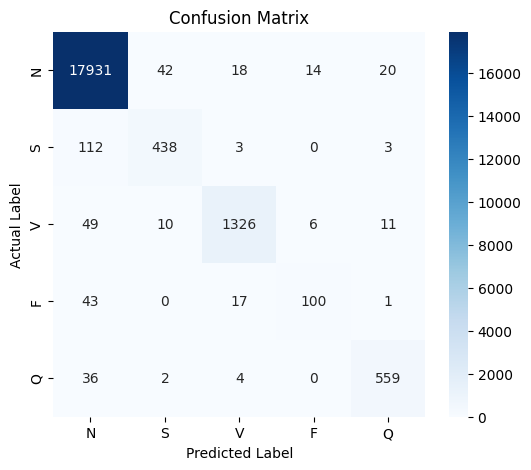

In [21]:
confusion_matrix_plot(y_test, y_pred)

Unique values in y_true_labels: {'S', 'V', 'N', 'Q', 'F'}
Unique values in y_pred_labels: {'S', 'V', 'N', 'Q', 'F'}

Classification Report:
               precision    recall  f1-score   support

           N       0.94      0.99      0.97     18025
           S       0.68      0.19      0.29       556
           V       0.92      0.80      0.86      1402
           F       0.86      0.55      0.67       161
           Q       0.87      0.46      0.60       601

    accuracy                           0.94     20745
   macro avg       0.85      0.60      0.68     20745
weighted avg       0.93      0.94      0.93     20745



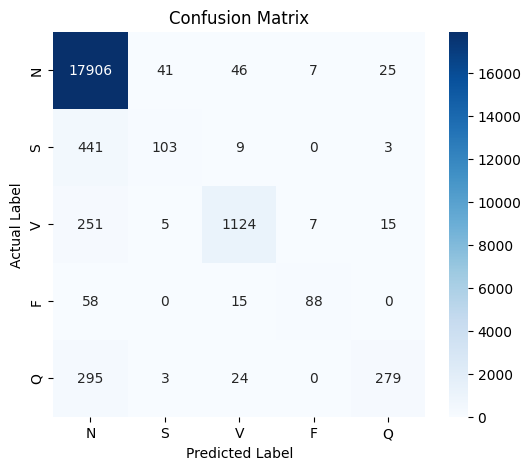

In [22]:
confusion_matrix_plot(y_test, y_pred_wo_std)

In [23]:
def plot_history(history):

    epochs = range(1, len(history.history['loss']) + 1)
    
  
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy')

    plt.show()

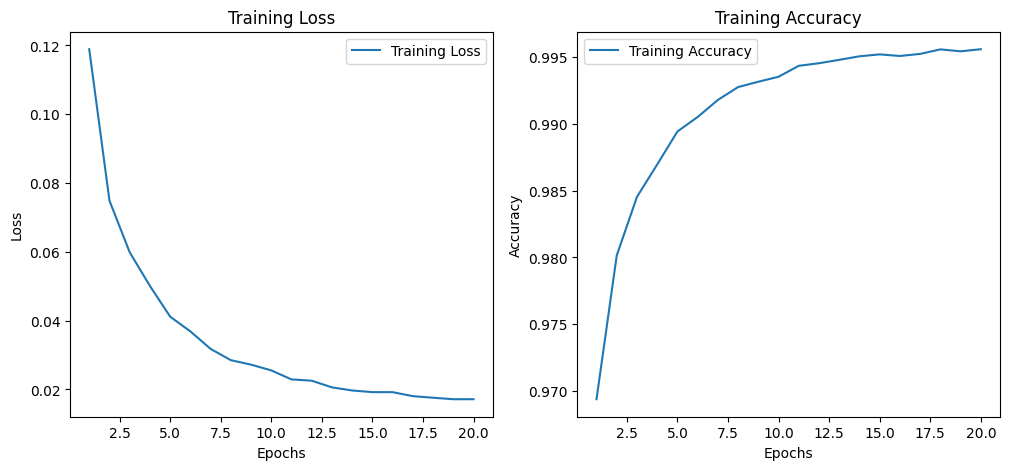

In [24]:
plot_history(history)

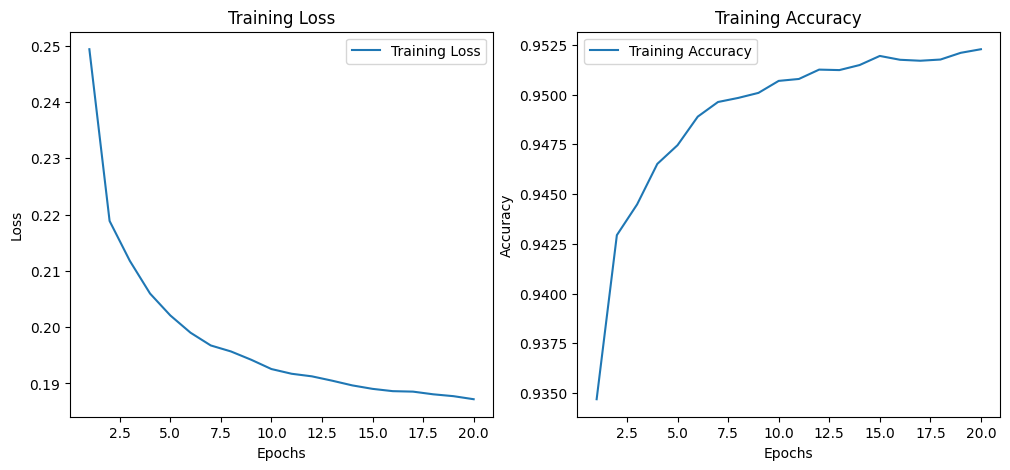

In [25]:
plot_history(history_wo_std)